In [1]:
from dotenv import load_dotenv
import os
import getpass

load_dotenv()

True

In [32]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"

In [33]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

In [34]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

In [35]:
python_repl = PythonREPL()

In [36]:
from langchain_experimental.utilities import PythonREPL
import sys
from io import StringIO

class PersistentPythonREPLTool(PythonREPL):
    def __init__(self):
        super().__init__()
        self._globals = {}

    def run(self, command: str) -> str:
        # Capture stdout
        old_stdout = sys.stdout
        sys.stdout = captured_output = StringIO()
        
        try:
            # First try eval (single expression)
            result = eval(command, self._globals)
            output = captured_output.getvalue()
            if output:
                return output + str(result)
            return str(result)
        except SyntaxError:
            # If it's a statement block, use exec
            try:
                exec(command, self._globals)
                output = captured_output.getvalue()
                return output if output else "Executed successfully with no output."
            except Exception as e:
                output = captured_output.getvalue()
                return output + repr(e) if output else repr(e)
        except Exception as e:
            output = captured_output.getvalue()
            return output + repr(e) if output else repr(e)
        finally:
            # Restore stdout
            sys.stdout = old_stdout

In [37]:
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be" \
                " a valid python command. If you want to see the output of a value, you " \
                "should print it out with `print(...)`.",
    func=python_repl.run,
)

In [41]:
from langchain_core.tools import tool

@tool(name_or_callable="generate_hint", description="Generate a helpful hint for a DSA problem without solving it.")
def generate_hint(question: str) -> str:
    """Generate a helpful hint for a DSA problem without solving it.
    input: question (str): The DSA problem to generate a hint for.
    output: str: A helpful hint for the DSA problem."""
    
    return llm.invoke(f"Give a helpful hint for this DSA problem without solving it: {question}").content

In [42]:
@tool(name_or_callable="generate_test_cases", description="Generate test cases for DSA problems without solving them.")
def generate_test_cases(problem_description: str) -> str:
    """Use this to generate test cases for DSA problems.
    input: problem_description - the DSA problem statement
    output: 3 test cases without solving the problem"""
    
    return llm.invoke(f"Create 3 test cases for this DSA problem without solving it: {problem_description}").content

In [43]:
@tool(name_or_callable="bug_hint_tool", description="Analyze code for logic issues and provide a subtle hint.")
def bug_hint_tool(code: str) -> str:
    """Use this to analyze code for logic issues and provide a subtle hint.
    input: code - the code to analyze
    output: str - a subtle hint about potential logic issues in the code.
    """

    return llm.invoke(f"Analyze this code for logic issues and give a subtle hint: {code}").content

In [44]:
@tool(name_or_callable="complexity_analyzer", description="Analyze time and space complexity of code")
def complexity_analyzer(code: str) -> str:
    """Analyze the time and space complexity of the given code."""
    prompt = f"""Analyze the time and space complexity of this code. Provide:
    1. Time complexity with explanation
    2. Space complexity with explanation
    3. Suggestions for optimization if any
    
    Code: {code}"""
    return llm.invoke(prompt).content

In [45]:
@tool(name_or_callable="code_quality_checker", description="Check code quality and suggest improvements")
def code_quality_checker(code: str) -> str:
    """Check code quality and suggest improvements."""
    prompt = f"""Review this code for:
    1. Readability and style
    2. Edge case handling
    3. Variable naming
    4. Code structure
    
    Code: {code}"""
    return llm.invoke(prompt).content

In [46]:
@tool(name_or_callable="recommend_problems", description="Recommend next problems based on progress")
def recommend_problems(current_topic: str = "", difficulty: str = "medium") -> str:
    """Recommend problems based on learning progression."""
    
    prompt = f"""Based on the current topic '{current_topic}' and difficulty '{difficulty}', 
    recommend 3 specific DSA problems that would be good next steps for learning. 
    Include problem names and brief descriptions."""
    
    return llm.invoke(prompt).content

In [49]:
@tool(name_or_callable="create_study_plan", description="Create personalized DSA study plan")
def create_study_plan(timeline_weeks: str, current_level: str, target_goals: str) -> str:
    """Create a personalized study plan for DSA preparation."""
    prompt = f"""Create a {timeline_weeks}-week DSA study plan for someone at {current_level} level 
    with goals: {target_goals}. Include:
    1. Week-by-week topics
    2. Number of problems per topic
    3. Key concepts to master
    4. Milestones to track progress"""
    
    return llm.invoke(prompt).content

In [61]:
tools = [
    repl_tool, 
    generate_hint, 
    generate_test_cases, 
    bug_hint_tool,
    complexity_analyzer,
    code_quality_checker,
    recommend_problems,
    create_study_plan
]

In [62]:
llm_with_tools = llm.bind_tools(tools)

In [63]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,SystemMessage,AnyMessage
from langgraph.graph import StateGraph, START

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [ ]:
sys_msg = SystemMessage(content=(
    "You are an expert DSA mentor using the Socratic method. Your goal is to guide students through problem-solving by asking questions and using tools proactively.\n\n"
    
    "CORE PRINCIPLES:\n"
    "1. NEVER give direct solutions - guide through questions and hints\n"
    "2. ALWAYS use tools proactively based on context, not just when asked\n"
    "3. Engage in meaningful conversations about problem-solving approach\n\n"
    
    "WHEN TO USE TOOLS AUTOMATICALLY:\n"
    "- When user shares a problem statement → use `generate_hint` and `generate_test_cases`\n"
    "- When user shares code → use `bug_hint_tool` to check for issues\n"
    "- After code is working → use `complexity_analyzer` and `code_quality_checker`\n"
    "- When user seems stuck → use `recommend_problems` for easier problems\n"
    "- When user wants to learn a topic → use `create_study_plan`\n"
    "- When testing solutions → use `python_repl` to run and verify code\n"
    
    "PROBLEM-SOLVING METHODOLOGY:\n"
    "1. Understand the problem (ask clarifying questions)\n"
    "2. Generate test cases (use `generate_test_cases`)\n"
    "3. Think of examples and edge cases\n"
    "4. Consider different approaches (use `generate_hint`)\n"
    "5. Implement solution step by step\n"
    "6. Test implementation (use `python_repl`)\n"
    "7. Debug if needed (use `bug_hint_tool`)\n"
    "8. Analyze complexity (use `complexity_analyzer`)\n"
    "9. Review code quality (use `code_quality_checker`)\n\n"
    
    "CONVERSATION FLOW:\n"
    "- Start each new problem by automatically generating hints and test cases\n"
    "- Ask probing questions about their approach\n"
    "- Use visualization tools to explain concepts\n"
    "- Run code automatically when they share solutions\n"
    "- Provide complexity analysis once code works\n"
    "- Recommend next problems based on progress\n\n"
    
    "Remember: Be proactive with tools to create an engaging learning experience!"
))

In [54]:
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import MessagesState

In [ ]:
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [56]:
graph = StateGraph(State)
graph.add_node("assistant", assistant)
graph.add_node("tools", ToolNode(tools))
graph.add_edge(START,"assistant")
graph.add_conditional_edges("assistant", tools_condition)
graph.add_edge("tools", "assistant")

In [57]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [58]:
app=graph.compile(checkpointer=memory)

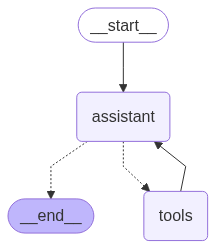

In [59]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [60]:
thread = {"configurable": {"thread_id": "123"}}

while True:
    # Get user input
    user_input = input("\nYou: ").strip()
    if user_input.lower() in {"exit", "quit", "cancel"}:
        print("Conversation ended.")
        break

    # Wrap input as a HumanMessage
    initial_input = {"messages": [HumanMessage(content=user_input)]}

    # Stream app output
    for event in app.stream(initial_input, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()


================================ Human Message =================================

help me with two sum problem
================================== Ai Message ==================================

Okay, I'm here to help! Let's start with the problem definition. Can you describe the Two Sum problem? I want to make sure we're on the same page.

Also, I'm going to generate some hints and test cases to get us started.
Tool Calls:
  generate_hint (dc464c52-f017-4924-945f-224507648914)
 Call ID: dc464c52-f017-4924-945f-224507648914
  Args:
    question: Two Sum problem
  generate_test_cases (53ac451c-bf10-4477-933c-c30261722e19)
 Call ID: 53ac451c-bf10-4477-933c-c30261722e19
  Args:
    problem_description: Two Sum problem
================================= Tool Message =================================
Name: generate_test_cases

Okay, here are 3 test cases for the Two Sum problem, without providing a solution.  The Two Sum problem states:

*   Given an array of integers `nums` and an integer `ta

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================

Okay, that's a great start! Now, let's test your code. I'll use the `python_repl` tool to run your function against the test cases we generated earlier.
Tool Calls:
  python_repl (469b75ca-52ae-4712-97e7-af8ffd542fe7)
 Call ID: 469b75ca-52ae-4712-97e7-af8ffd542fe7
  Args:
    __arg1: def two_sum(nums, target):
    num_map = {}  # value -> index
    for i, num in enumerate(nums):
        complement = target - num
        if complement in num_map:
            return [num_map[complement], i]
        num_map[num] = i


nums1 = [2, 7, 11, 15]
target1 = 9
print(two_sum(nums1, target1))

nums2 = [-1, -3, 4, 0]
target2 = -4
print(two_sum(nums2, target2))

nums3 = [324, 678, 234, 987, 123, 567]
target3 = 1554
print(two_sum(nums3, target3))
================================= Tool Message =================================
Name: python_repl

[0, 1]
[0, 1]
[3, 5]

================================== Ai Message =========